# Vấn đề/điểm cần lưu ý

Chuẩn hóa vector: CLIP thường tốt nhất khi chuẩn hóa embedding (unit norm). Nếu chuẩn hóa, dùng inner-product (cosine similarity) thay vì L2 để so sánh trực tiếp.

Kiểu dữ liệu FAISS: FAISS yêu cầu float32 (không phải float64). Hãy ensure np.float32.

Xử lý batch: Nếu có nhiều ảnh, encode theo batch để tránh đầy RAM.

Lưu index & paths: Nên lưu faiss index và file list để không phải rebuild mỗi lần.

Hiển thị ảnh: Mở ảnh bằng PIL hoặc hiển thị bằng matplotlib nếu muốn nhìn kết quả.

Ý nghĩa distance:

Với IndexFlatL2: số nhỏ hơn = càng giống (khoảng cách Euclidean).

Với IndexFlatIP trên vector chuẩn hóa: giá trị lớn hơn = càng giống (inner product ≈ cosine).

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 27.6MiB/s]


Encoded 10 images. dim = 512
FAISS index contains: 10
Saved index -> castle_index.faiss and paths -> castle_image_paths.txt
Query: a castle on a hill
1. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_2252.JPEG    score=0.3074


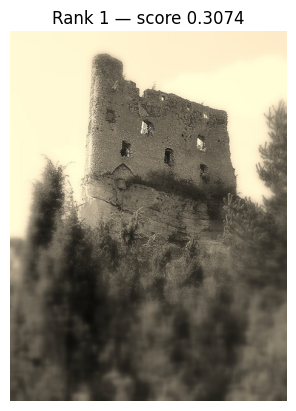

2. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_2971.JPEG    score=0.2837


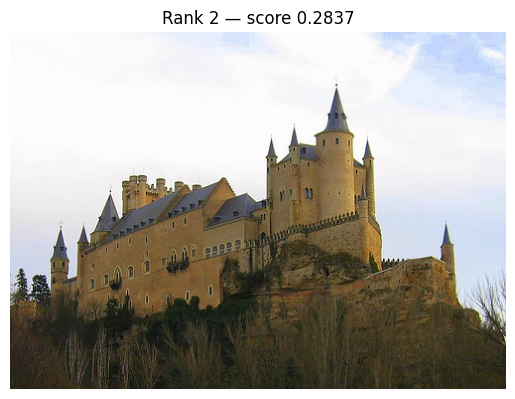

3. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_2391.JPEG    score=0.2799


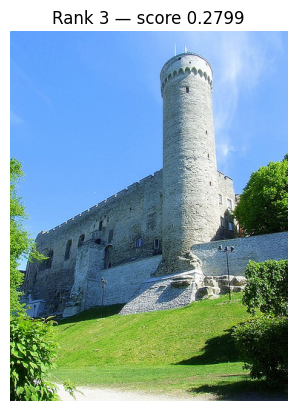

In [17]:
import numpy as np
import torch
import clip
from PIL import Image
import faiss
import os
import matplotlib.pyplot as plt

# ---------------------
# 0. Cấu hình
# ---------------------
device = "cpu"  # máy Dell AMD không có CUDA
image_folder = r"D:\Big_project_2025\Text-to-Image\images_folder\train\castle"
index_file = "castle_index.faiss"
paths_file = "castle_image_paths.txt"
batch_size = 16

# ---------------------
# 1. Load model CLIP
# ---------------------
model, preprocess = clip.load("ViT-B/32", device=device)

# ---------------------
# 2. Lấy danh sách ảnh
# ---------------------
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if len(image_files) == 0:
    raise SystemExit("Không tìm thấy ảnh trong folder: " + image_folder)

# ---------------------
# 3. Encode ảnh theo batch, chuẩn hóa, và tạo matrix float32
# ---------------------
features = []
for i in range(0, len(image_files), batch_size):
    batch_paths = image_files[i:i+batch_size]
    imgs = []
    for p in batch_paths:
        img = Image.open(p).convert("RGB")
        imgs.append(preprocess(img).unsqueeze(0))
    imgs_tensor = torch.cat(imgs).to(device)
    with torch.no_grad():
        feats = model.encode_image(imgs_tensor)            # torch tensor
        feats = feats / feats.norm(dim=-1, keepdim=True)  # normalize
    features.append(feats.cpu().numpy().astype('float32'))

features_np = np.vstack(features)  # shape (N, dim)
dim = features_np.shape[1]
print("Encoded", features_np.shape[0], "images. dim =", dim)

# ---------------------
# 4. Build FAISS index (use Inner Product on normalized vectors => cosine)
# ---------------------
index = faiss.IndexFlatIP(dim)  # inner product
index.add(features_np)
print("FAISS index contains:", index.ntotal)

# (Tùy chọn) Lưu index và image paths để dùng lần sau
faiss.write_index(index, index_file)
with open(paths_file, "w", encoding="utf-8") as f:
    for p in image_files:
        f.write(p + "\n")
print("Saved index ->", index_file, "and paths ->", paths_file)

# ---------------------
# 5. Hàm search và hiển thị
# ---------------------
def search_text(query, k=5, show=True):
    # encode text
    text_tokens = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_feat = model.encode_text(text_tokens)
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    text_np = text_feat.cpu().numpy().astype('float32')

    # search (inner product, higher = better)
    D, I = index.search(text_np, k)  # D: scores (IP), I: indices
    scores = D[0]
    inds = I[0]

    print(f"Query: {query}")
    for rank, (idx, score) in enumerate(zip(inds, scores), start=1):
        path = image_files[idx]
        print(f"{rank}. {path}    score={score:.4f}")
        if show:
            img = Image.open(path)
            plt.imshow(img)
            plt.title(f"Rank {rank} — score {score:.4f}")
            plt.axis('off')
            plt.show()

# ---------------------
# 6. Thử search
# ---------------------
if __name__ == "__main__":
    search_text("a castle on a hill", k=3)


Query: a hill
1. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_2252.JPEG    score=0.2630


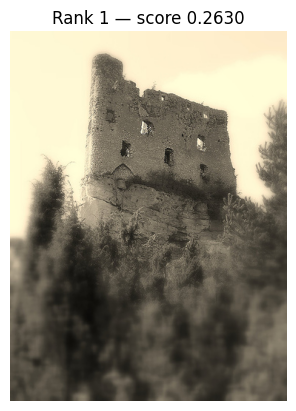

2. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_37573.JPEG    score=0.2387


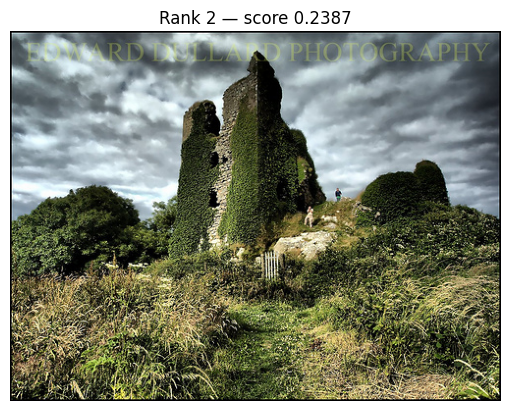

3. D:\Big_project_2025\Text-to-Image\images_folder\train\castle\n02980441_2391.JPEG    score=0.2302


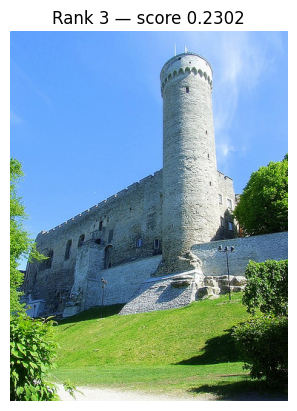

In [18]:
# ---------------------
# 6. Thử search
# ---------------------
if __name__ == "__main__":
    search_text("a hill", k=3)